In [58]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [59]:
# dataset paths
data_train_path = './train_folder'
data_test_path = './test_folder'

# Classes
# classes = os.listdir(data_train_path)
classes = [cls for cls in os.listdir(data_train_path) if cls != 'Woodpecker']
num_classes = len(classes)

print("Total number of classes: " + str(num_classes))

Total number of classes: 8


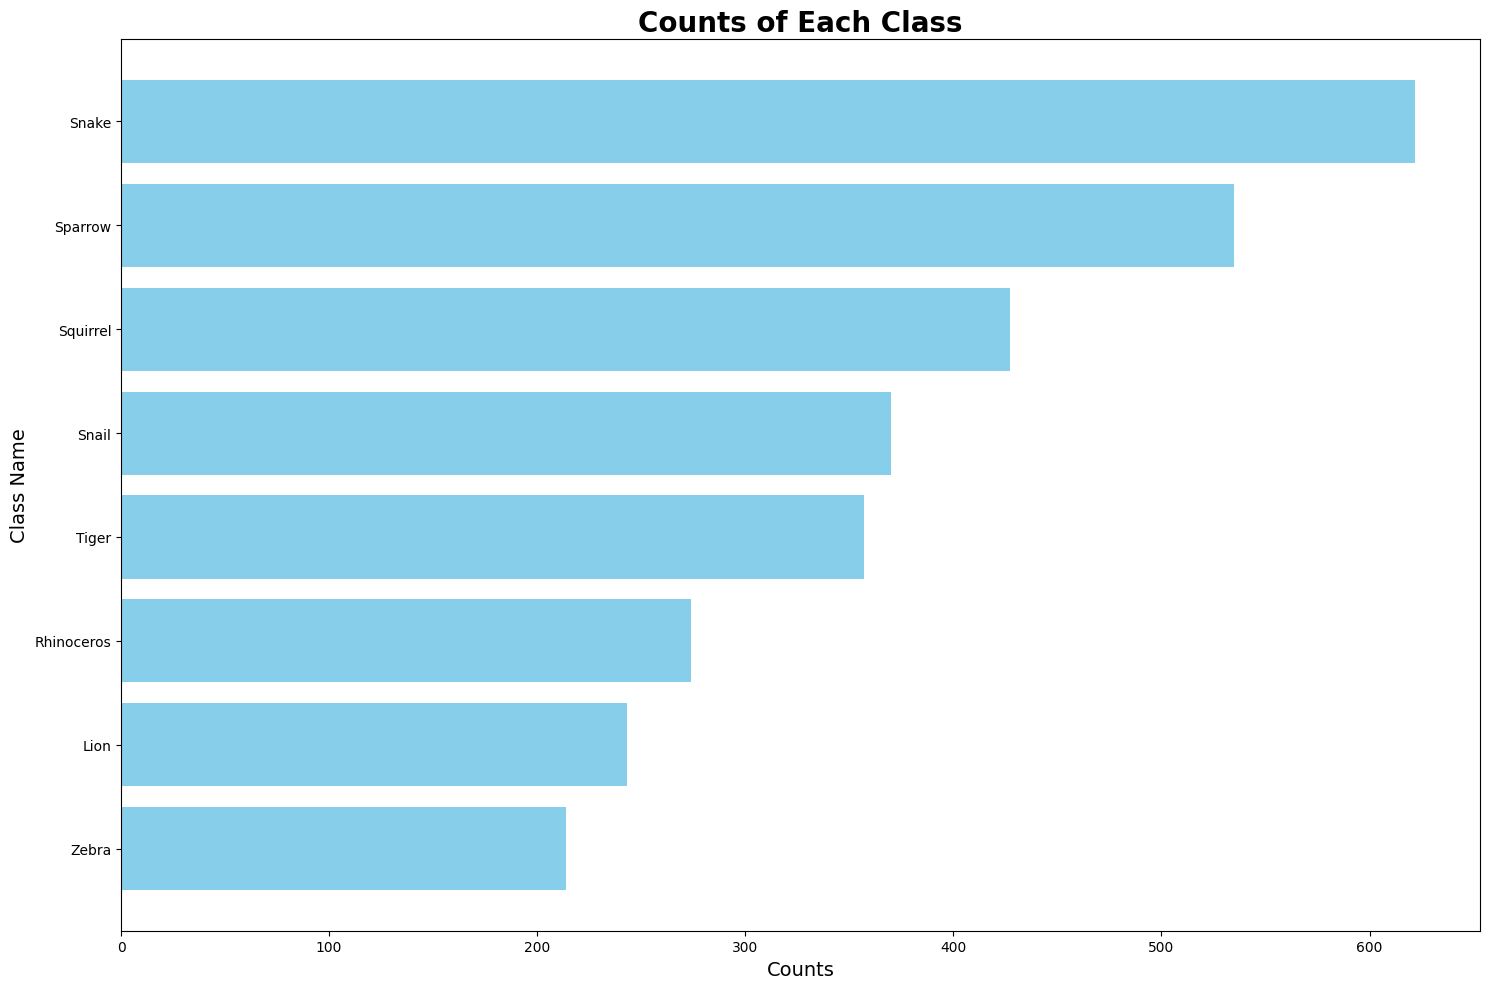

In [60]:
counts = []

for n_class in classes:
    class_path = os.path.join(data_train_path, n_class)
    count = len(os.listdir(class_path))
    counts.append((n_class, count))

counts = pd.DataFrame(counts, columns=['Class Name', 'Counts'])

counts = counts.sort_values(by='Counts', ascending=False)

plt.figure(figsize=(15, 10))
plt.barh(counts['Class Name'], counts['Counts'], color='skyblue')
plt.xlabel('Counts', fontsize=14)
plt.ylabel('Class Name', fontsize=14)
plt.title('Counts of Each Class', fontsize=20, fontweight='bold')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

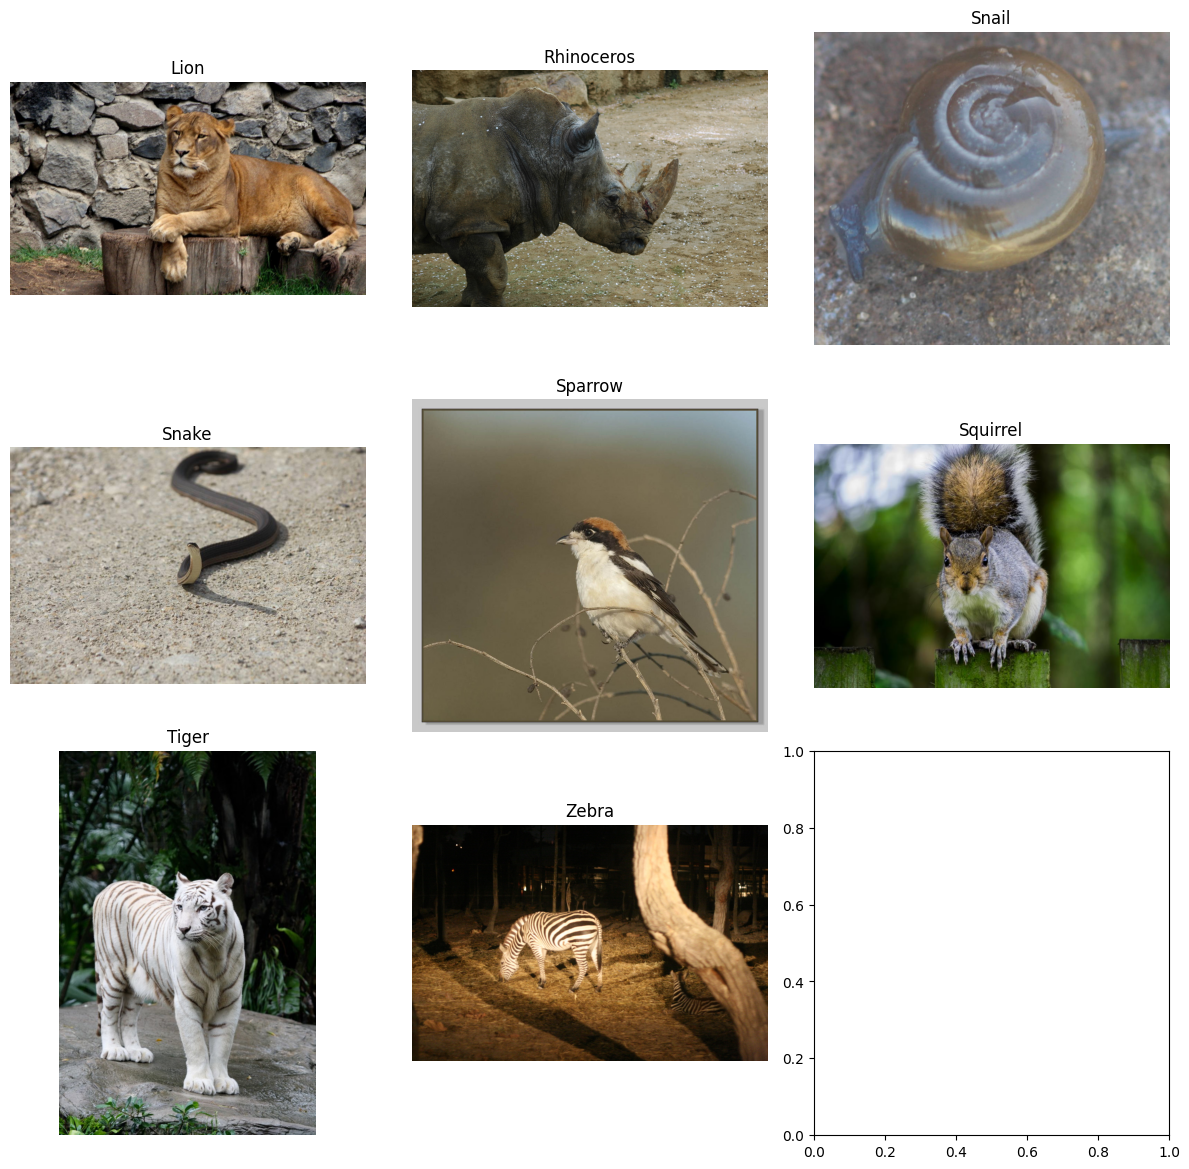

In [61]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))  # grelha 3x3 para 9 classes

for i in range(len(classes)):
    class_name = classes[i]
    class_path = os.path.join(data_train_path, class_name)
    
    img_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
    img_path = os.path.join(class_path, img_files[0])
    
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    row = i // 3
    col = i % 3

    ax[row, col].imshow(img)
    ax[row, col].axis('off')
    ax[row, col].set_title(class_name)

plt.tight_layout()
plt.show()

In [62]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
SIZE = IMAGE_SIZE[0]

# Load the full training dataset (will be split later)
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_train_path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
)

# Preprocessing and performance optimization
full_train_ds = full_train_ds.shuffle(1024).prefetch(tf.data.AUTOTUNE)

# Count total number of batches
total_batches = tf.data.experimental.cardinality(full_train_ds).numpy()
train_batches = int(0.9 * total_batches)
val_batches = total_batches - train_batches

# Dividir o dataset em treino (90%) e validação (10%)
train_ds = full_train_ds.take(train_batches)
valid_ds = full_train_ds.skip(train_batches)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply augmentation and normalization to training set
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)

# Apply only normalization to validation set
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)

# Split the dataset: 90% for training and 10% for validation
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=data_test_path,
    labels='inferred',
    label_mode='categorical',
    class_names=classes,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
)

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(tf.data.AUTOTUNE)

# Print dataset sizes
print("Total batches:", total_batches + tf.data.experimental.cardinality(test_ds).numpy())
print("Train batches:", train_batches)
print("Validation batches:", val_batches)
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())


Found 3042 files belonging to 8 classes.
Found 712 files belonging to 8 classes.
Total batches: 119
Train batches: 86
Validation batches: 10
Test batches: 23


In [63]:
# model = Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(SIZE, SIZE, 3)),  # 1º bloco
#     layers.MaxPooling2D((2, 2)),

#     layers.Conv2D(64, (3, 3), activation='relu'),  # 2º bloco
#     layers.MaxPooling2D((2, 2)),

#     layers.Conv2D(128, (3, 3), activation='relu'),  # 3º bloco
#     layers.MaxPooling2D((2, 2)),

#     layers.Flatten(),  # transforma em vetor
#     layers.Dense(128, activation='relu'),  # camada densa
#     layers.Dropout(0.5),  # evita overfitting
#     layers.Dense(num_classes, activation='softmax')  # saída para classificação
# ])

model = Sequential([
    # Bloco 1
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Bloco 2
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Bloco 3
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Bloco 4 (opcional, se quiseres mais profundidade)
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Classificação
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


c:\Users\jguid\TAA_Project\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [64]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train model by .fit function
history = model.fit(
    train_ds,                                          # Dataset to train model
    epochs=50,                                        # Number of epochs to train
    validation_data=valid_ds                          # Validation dataset
)

Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.2069 - loss: 3.3182 - val_accuracy: 0.0969 - val_loss: 7.7971
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.2677 - loss: 1.9495 - val_accuracy: 0.1069 - val_loss: 9.2866
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.2976 - loss: 1.8960 - val_accuracy: 0.1531 - val_loss: 7.7047
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.3171 - loss: 1.8063 - val_accuracy: 0.2250 - val_loss: 4.3638
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.3534 - loss: 1.7645 - val_accuracy: 0.3063 - val_loss: 2.3024
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.3228 - loss: 1.7735 - val_accuracy: 0.3759 - val_loss: 1.5835
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.3809 - loss: 1.7314 - val_accuracy: 0.4250 - val_loss: 1.5702
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.3831 - loss: 1.6657 - val_accuracy: 0.4875 - v

In [66]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
# Show 5 tails of dataframe
result_df.tail()

,accuracy,loss,val_accuracy,val_loss
25,0.534166,1.258006,0.609375,1.053046
26,0.536003,1.299880,0.612500,1.076290
27,0.558413,1.247690,0.628125,1.064277
28,0.555841,1.231994,0.593103,1.143199
29,0.563556,1.211706,0.578125,1.441149


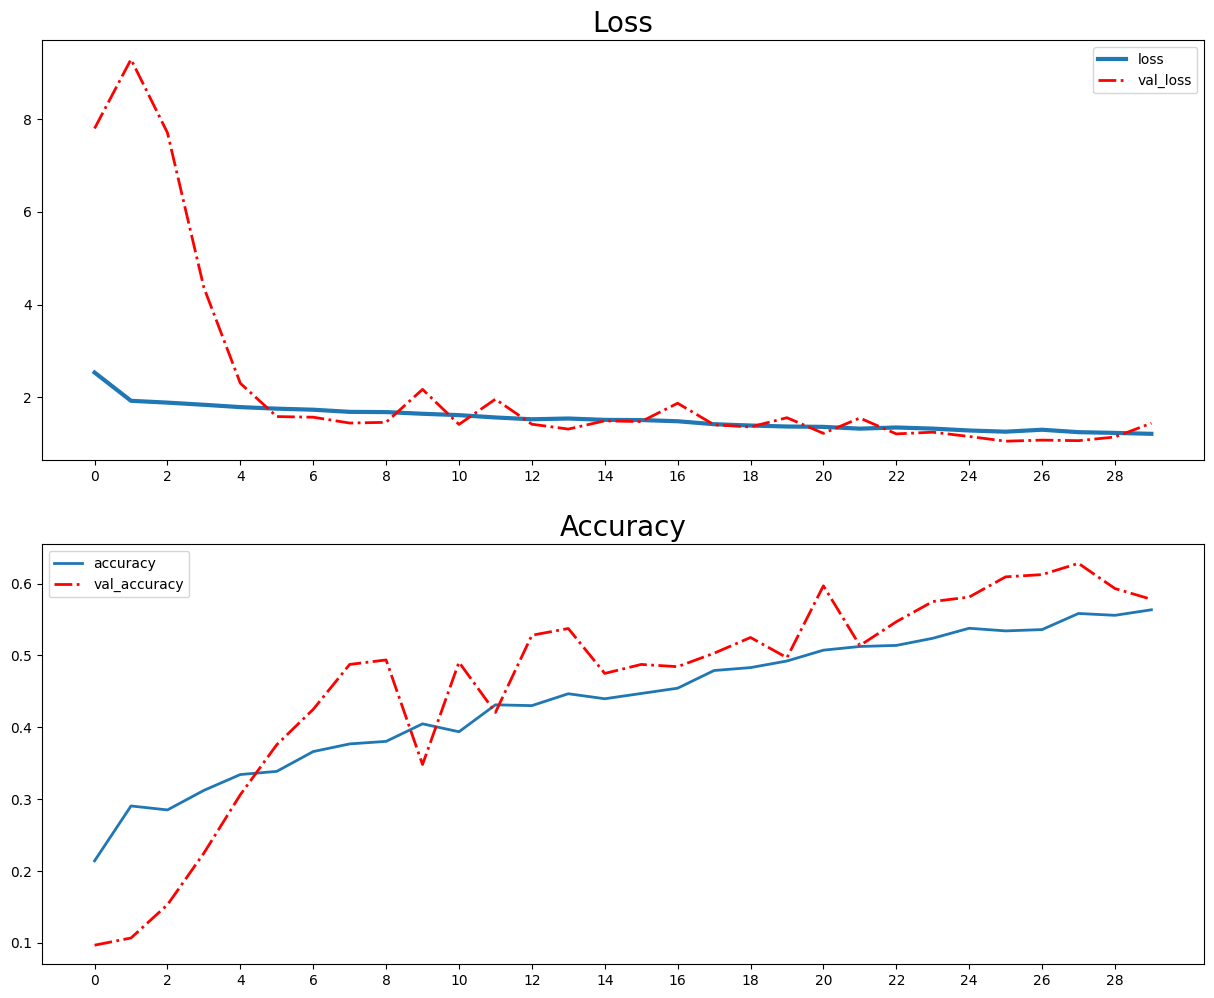

In [67]:
# Define a X variable to store range of epochs
x = np.arange(len(result_df))

# Create a plot with 3 row and 1 col with size of (15, 12)
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

# AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)                          
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].set_xticks(np.arange(0, len(x), 2))
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].set_xticks(np.arange(0, len(x), 2))
ax[1].legend()

# #  AX2 : Loss
# ax[2].plot(x, result_df.learning_rate, label='learning_rate', linewidth=2, marker='o')
# ax[2].set_title('learning_rate', fontsize=20)
# ax[2].set_xlabel('epochs')
# ax[2].set_xticks(np.arange(0, len(x), 2))
# ax[2].legend()

plt.show()

In [68]:
# checkpoint callback, save base model weights in "MyModel.keras".
# So, we should load it by keras.models.load_model
# best_model = tf.keras.models.load_model('MyModel.keras')

In [69]:
# Evaluate model by model.evaluate()
loss, accuracy = model.evaluate(test_ds)
print()
print(f'Loss : {loss}')
print(f'Accuracy : {accuracy*100}%')

23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step - accuracy: 0.3144 - loss: 2.0191

Loss : 1.7824299335479736
Accuracy : 40.73033630847931%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


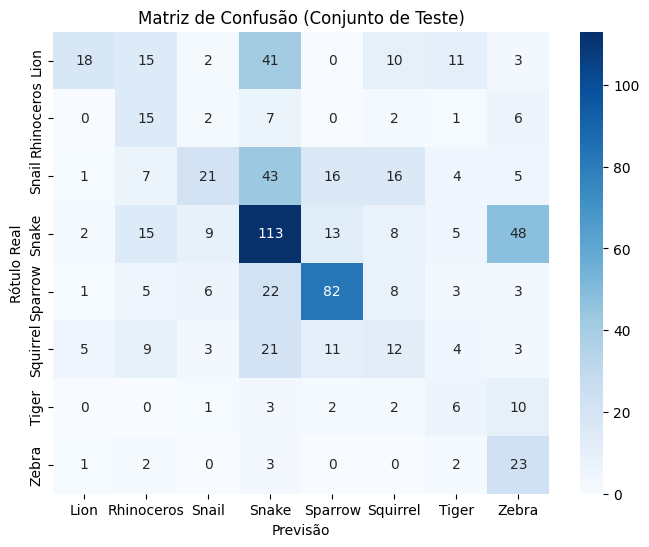

In [70]:
# Matriz de confusão

# Obter previsões e rótulos reais do conjunto de teste
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
class_names = classes  # use the already defined list of class names

# Visualização
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsão')
plt.ylabel('Rótulo Real')
plt.title('Matriz de Confusão (Conjunto de Teste)')
plt.show()